In [ ]:
!pip install razdel
!pip install heapdict

In [1]:
from collections import Counter, defaultdict
import json
import os
import random
import re

from heapdict import heapdict
import numpy as np
import pandas as pd
import razdel
from tqdm.auto import tqdm, trange
import torch
from transformers import (
    Adafactor,
    AutoModel,
    AutoModelForPreTraining,
    AutoTokenizer,
    BertTokenizer,
    DataCollatorForWholeWordMask
)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/diploma/data

accuracies.csv		aligned_sents.json  losses.csv	      moksha_bible.tsv
aligned_name_pairs.tsv	all_dicts_data.tsv  mdf_mono	      ru_names_df.tsv
aligned_pairs.pkl	all_phrases.tsv     mdf_names_df.tsv  text_for_align


In [ ]:
DATA_PATH_PREFIX = 'drive/MyDrive/diploma/data/'

In [ ]:
BASE_MODEL = 'cointegrated/LaBSE-en-ru'

# Collect the data

## Monolang data

1. books from uni
2. books from wikisource
3. news from e-mordovia (use only subset of them)
4. bible (use only subset of them)

In [ ]:
books_sents = []

In [ ]:
book_dir = DATA_PATH_PREFIX + 'mdf_mono/'

# load all sents from mdf books
for fn in os.listdir(book_dir):
    if not fn.endswith('.txt'):
      continue

    print(fn)
    with open(book_dir + fn, 'r') as f:
        raw_lines = f.readlines()

    raw_text = ''.join(raw_lines).replace('\xa0', ' ')
    raw_text = re.sub('\s+', ' ', raw_text).strip().replace('* ', '')

    sents = []
    for sent in list(razdel.sentenize(raw_text)):
        text = sent.text.replace('-\n', '').replace('\n', ' ').strip()
        if len(text) >= 3 and len(text) <= 500:
            sents.append(text)
    print(len(sents))

    books_sents.extend(sents)

print()
print(len(books_sents))

Мишанина_Кенерсь_тишесь.txt
173
Мишанина_Сокор_веле.txt
1062
Вешкин_Лядсь.txt
134
Кишняков_Полю.txt
639
Кузнецов_Ожудова,_вишке_волохт.txt
6138
Моиисеев_Оду_аф_няйсамасть.txt
9941
Мокшони_Митрей.txt
503
Лобанов.txt
9217
27807


In [ ]:
book_dir = DATA_PATH_PREFIX + 'text_for_align/'

# load all sents from books for next alignment
for fn in os.listdir(book_dir):
    if not fn.endswith('.json'):
        continue

    with open(book_dir + fn, 'r') as f:
        dicts = json.load(f)

    for url, raw_text in dicts.items():
        # delete ru links
        if not url.startswith('https://wikisource.org/wiki/'):
            continue

        raw_text = raw_text.replace('\xa0', ' ')
        raw_text = re.sub('\s+', ' ', raw_text).strip().replace('* ', '')

        sents = []
        for sent in list(razdel.sentenize(raw_text)):
            text = sent.text.replace('-\n', '').replace('\n', ' ').strip()
            if len(text) >= 3 and len(text) <= 500:
                sents.append(text)

        books_sents.extend(sents)

print(len(books_sents))

34310


In [ ]:
random.choice(books_sents)

'Мзярце шись ни Валентин васта лангса!'

In [23]:
news_sents = []

In [24]:
# load all names and all texts from raw df with news' texts
mdf_names_df = pd.read_csv(DATA_PATH_PREFIX + 'mdf_names_df.tsv', sep='\t')

for col in ['name', 'text']:
    for raw_text in mdf_names_df[col]:
        raw_text = raw_text.replace('\xa0', ' ')
        raw_text = re.sub('\s+', ' ', raw_text).strip().replace('* ', '')

        sents = []
        for sent in list(razdel.sentenize(raw_text)):
            text = sent.text
            # text = sent.text.replace('-\n', '').replace('\n', ' ').strip()
            if len(text) >= 3 and len(text) <= 500:
                sents.append(text)
        news_sents.extend(sents)
    print(len(news_sents))

4695
85488


In [25]:
for s in news_sents:
    if '\n' in s:
        print(s)

In [ ]:
moksha_bible = pd.read_csv(DATA_PATH_PREFIX + 'moksha_bible.tsv', sep='\t')
bible_sentences = moksha_bible.mdf.dropna().tolist()
len(bible_sentences)

11633

In [ ]:
random.choice(bible_sentences)

'Нятка Соломононь валмуворксонза, конатнень кочказь Езекиянь, Иудеянь оцязорть, ломаненза.'

In [ ]:
random.seed(42) # save seed for `random.sample`

mdf_sentences = sorted(set(
    books_sents + random.sample(news_sents, k=10000) + random.sample(bible_sentences, k=5000)
))

print(len(mdf_sentences))

48434


## Sentence-parallel data

1. bible (11.5k pairs)
2. dictionaries (3.6k pairs of words and 700 pairs of phrases)

In [ ]:
bible_df = pd.read_csv(DATA_PATH_PREFIX + 'moksha_bible.tsv', sep='\t')
print(bible_df.shape)

bible_df = bible_df.dropna()
print(bible_df.shape)

bible_df = bible_df[~bible_df['mdf'].str.startswith('Глава ')]
print(bible_df.shape)
print(bible_df.columns)

(11650, 4)
(11633, 4)
(11583, 4)
Index(['Unnamed: 0', 'mdf', 'ru', 'source'], dtype='object')


In [ ]:
assert not bible_df.isna().sum().sum()

In [ ]:
bible_pairs = list(zip(bible_df['mdf'], bible_df['ru']))
print(len(bible_pairs))

11583


('Мон содаса: тейне курок сави кадомс тя ронгть – тянь тейне панжезе Иисус Христос Азороньке.',
 'зная, что скоро должен оставить храмину мою, как и Господь наш Иисус Христос открыл мне.')

In [ ]:
random.choice(bible_pairs)

In [ ]:
word_df = pd.read_csv(DATA_PATH_PREFIX + 'all_dicts_data.tsv', sep='\t')

In [ ]:
assert not word_df.isna().sum().sum()

In [ ]:
word_pairs = list(zip(word_df['mdf'], word_df['ru']))
print(len(word_pairs))

3589


('петемс', 'чинить')

In [ ]:
random.choice(word_pairs)

In [ ]:
phrases_df = pd.read_csv(DATA_PATH_PREFIX + 'all_phrases.tsv', sep='\t')

In [ ]:
assert not phrases_df.isna().sum().sum()

In [ ]:
phrases_pairs = list(zip(phrases_df['mdf'], phrases_df['ru']))
print(len(phrases_pairs))

726


('Мольхтяма калонь кундама?', 'Пойдем на рыбалку?')

In [ ]:
random.choice(phrases_pairs)

In [ ]:
parallel_pairs = sorted({
    c for c in
    word_pairs + phrases_pairs + bible_pairs
    if c[0] and c[1]
})
print(len(parallel_pairs))

15898


In [ ]:
mdf_sentences = sorted(set(
    mdf_sentences + [e for e, r in parallel_pairs if len(e.split()) >= 3]
))
print(len(mdf_sentences))

55472


# Model vocabulary analisis and update

In [ ]:
tokenizer = BertTokenizer.from_pretrained(BASE_MODEL)

In [ ]:
print(tokenizer.vocab_size)

## get stat for each word in corpora

In [ ]:
word_count = Counter()

for text in tqdm(mdf_sentences):
    word_count.update(tokenizer.basic_tokenizer.tokenize(text))

  0%|          | 0/55472 [00:00<?, ?it/s]

In [ ]:
print(len(word_count))
word_count.most_common(20)

87543


[(',', 70080),
 ('.', 58700),
 ('и', 20206),
 ('—', 14057),
 ('-', 10090),
 ('аф', 9623),
 (':', 8013),
 ('?', 5192),
 ('!', 5044),
 ('«', 4442),
 ('»', 4373),
 ('а', 3994),
 ('мархта', 3589),
 ('сон', 3501),
 ('кода', 3348),
 ('тя', 2978),
 ('А', 2916),
 ('синь', 2824),
 ('эсь', 2717),
 ('сонь', 2637)]

## get most frequent tokens pairs in corpora

In [ ]:
pairs_count = Counter()
pair2word = defaultdict(set)

for w, c in tqdm(word_count.items(), total=len(word_count)):
    tokens = tokenizer.wordpiece_tokenizer.tokenize(w) 
    for pair in zip(tokens[:-1], tokens[1:]):
        pairs_count[pair] += c
        pair2word[pair].add(w)

  0%|          | 0/87543 [00:00<?, ?it/s]

In [ ]:
# create heap_dict to peek most frequent token pair in each step

hd = heapdict()

for w, c in pairs_count.items():
    hd[w] = -c

## replace frequent pair by their concat

In [ ]:
replace_count = 100_000
min_frequency = 30

In [ ]:
# list, where each element contains list of base tokens' id
# needs to calculate initial weight values of new token
id2ids = [[idx] for tok, idx in tokenizer.vocab.items()]  

# dict for quick get idx using token
tok2id = {tok: idx for tok, idx in tokenizer.vocab.items()}

# dict for get updated representaion of words in vocabulary
word2toks = {w: tokenizer.wordpiece_tokenizer.tokenize(w) for w in tqdm(word_count)}

In [ ]:
def get_new_tokens_list(old_tokens, pair, new_token):
    result = []

    prev = old_tokens[0]
    for tok in old_tokens[1:]:
        if (prev, tok) == pair:
            result.append(new_token)
            prev = None
        else:
            if prev is not None:
                result.append(prev)
            prev = tok
    if prev is not None:
        result.append(prev)
    
    return result

In [ ]:
def update_word_stat(word, old_toks, new_toks, delta):
    word2toks[word] = new_toks
    wc = word_count[word]
    
    # for each tokens pair in old_toks substract `wc` 
    # substract freq for pairs with concated tokens and unchanged pairs
    for old_pair in zip(old_toks[:-1], old_toks[1:]):
        delta[old_pair] -= wc
        if word in pair2word[old_pair]:
            pair2word[old_pair].remove(word)
    
    # for each tokens pair in new_pair add `wc` 
    # add freq for new pair and unchanged pairs
    for new_pair in zip(new_toks[:-1], new_toks[1:]):
        delta[new_pair] += wc
        pair2word[new_pair].add(word)

In [ ]:
extra_vocab = []
extra_counts = []

In [ ]:
for _ in trange(replace_count):
    # get the most frequent tokens pair
    # change it with their concat
    # update stat for each word using new token
    # update stat for all tokens pair

    pair, count = hd.peekitem()
    count = -count

    if count < min_frequency:
        break
    new_token = pair[0] + pair[1][2:]  # use [2:] for deleting ##
    extra_vocab.append(new_token)
    extra_counts.append(c)

    # update the vocabulary
    tok2id[new_token] = len(id2ids)
    id2ids.append(id2ids[tok2id[pair[0]]] + id2ids[tok2id[pair[1]]])

    # calculate the delta for the heap
    delta = Counter()
    for word in list(pair2word[pair]):
        # calculate old and new ways to tokenize the word
        old_toks = tokenizer.wordpiece_tokenizer.tokenize(word)
        new_toks = get_new_tokens_list(old_toks, pair, new_token)

        update_word_stat(word, old_toks, new_token, delta)
        
    # update the heap
    for a_pair, a_delta in delta.items():
        if a_delta == 0:
            continue
        if a_pair not in hd:
            hd[a_pair] = 0
        hd[a_pair] -= a_delta

  0%|          | 0/100000 [00:00<?, ?it/s]

## update tokenizer

In [ ]:
print(len(extra_vocab))

4564


In [ ]:
tmp_tok = 'tmp_tok'
tokenizer.save_pretrained(tmp_tok)

('tmp_tok/tokenizer_config.json',
 'tmp_tok/special_tokens_map.json',
 'tmp_tok/vocab.txt',
 'tmp_tok/added_tokens.json')

In [ ]:
with open(tmp_tok + '/vocab.txt', 'a') as f:
    for token in extra_vocab:
        f.write(token + '\n')

In [ ]:
new_tokenizer = BertTokenizer.from_pretrained(tmp_tok)

In [ ]:
len(tokenizer.vocab) + len(tokenizer.get_added_vocab())

In [ ]:
print(len(new_tokenizer.vocab) + len(new_tokenizer.get_added_vocab()))

59652


In [ ]:
random.seed(1)
sample_texts = random.choices(mdf_sentences, k=1000)

In [ ]:
old_len = np.mean([len(tokenizer.tokenize(t)) for t in sample_texts])
print(old_len)

34.111


In [ ]:
new_len = np.mean([len(new_tokenizer.tokenize(t)) for t in sample_texts])
print(new_len)

20.851
0.6112690920817332


In [ ]:
print(new_len / old_len)

## save model for new vocab

In [ ]:
model = AutoModelForPreTraining.from_pretrained(BASE_MODEL)

In [ ]:
model.resize_token_embeddings(new_tokenizer.vocab_size)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Embedding(59647, 768, padding_idx=0)

In [ ]:
for i, ids_from in enumerate(tqdm(id2ids)):
    if len(ids_from) == 1:
        continue
    model.bert.embeddings.word_embeddings.weight.data[i] = model.bert.embeddings.word_embeddings.weight.data[ids_from].mean(0)

  0%|          | 0/59647 [00:00<?, ?it/s]

In [ ]:
NEW_MODEL_NAME = 'labse_moksha_v0'
model.save_pretrained(NEW_MODEL_NAME)
new_tokenizer.save_pretrained(NEW_MODEL_NAME)

('labse_moksha_v0/tokenizer_config.json',
 'labse_moksha_v0/special_tokens_map.json',
 'labse_moksha_v0/vocab.txt',
 'labse_moksha_v0/added_tokens.json')

# Training the model: base

In [ ]:
def get_acc(e1, e2):
    batch_size = e1.shape[0]
    with torch.no_grad():
        scores = torch.matmul(e1, e2.T).cpu().numpy()
    a1 = (scores.argmax(1) == np.arange(batch_size)).mean()
    a2 = (scores.argmax(0) == np.arange(batch_size)).mean()
    return (a1 + a2) / 2

In [ ]:
def test_model(model, tokenizer):
    with torch.inference_mode():
        test_ru = [
            'картофель',
            'резать хлеб',
            'Федор полон был рассказами Гриши.',
            'Перед ним стояла неотвязно, волновала, мучила и радовала сказочная фигура Чапаева, степного атамана.',
            'Те в свое время свои дела делали, а этому другое время дано — он и дела творит не те.',
        ]
        test_mdf = [
            'модамарь',
            'керемс кши',
            'Федорсь марнек пяшкотьфоль Гришань азондоманзон мархта. ',
            'Сонь инголенза аф явондозь ащесь, кепсезе мяленц, муцязе и кенярьфнезе Чапаевонь, степонь атаманть сказочнай фигурац.',
            'Тонат эсь пингстост эсь тевснон тиендезь, а тянди лия пинге максф, сон и тефтка тиенди аф стапт. ',
        ]

        batch = tokenizer(test_ru+test_mdf, return_tensors='pt', padding=True, truncation=True, max_length=128).to(model.device)
        out = model.bert(**batch, output_hidden_states=True)
        embeddings = torch.nn.functional.normalize(out.pooler_output)
        
    alignment = torch.matmul(
        embeddings[:5],
        embeddings[5:].T
    )

    return alignment

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_for_report(
        values, 
        ylabel
    ):
    _, ax = plt.subplots(figsize=(10, 6))
    pd.Series(values).ewm(1000).mean()[50:].plot(ax=ax)

    ax.set_xlabel("Число шагов", fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.2f}".replace('.', ',')))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}".replace(',', ' ')))

    ax.grid(True)
    plt.tight_layout()

In [ ]:
MODEL_DIR = 'drive/MyDrive/diploma/labse_moksha_50k+50k'

model = AutoModelForPreTraining.from_pretrained(MODEL_DIR)
tokenizer = BertTokenizer.from_pretrained(MODEL_DIR)

In [ ]:
model.cuda();

# Training the model: 1 - training of embeddings

In [ ]:
for p in model.parameters():
    p.requires_grad = False
for p in model.bert.embeddings.word_embeddings.parameters():
    p.requires_grad = True

In [ ]:
batch_size = 4
margin = 0.3
lr = 1e-5
clip_threshold=1.0

In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False, relative_step=False, lr=lr, clip_threshold=clip_threshold
)

In [ ]:
def train_alignment(parallel_pairs, step_count, optimizer):
    losses = []
    accuracies = []

    loss_fn = torch.nn.CrossEntropyLoss()

    model.train()
    for i in trange(step_count):
        mdf, ru = [list(p) for p in zip(*random.choices(parallel_pairs, k=batch_size))]
        try:
            batch = tokenizer(ru+mdf, return_tensors='pt', padding=True, truncation=True, max_length=128).to(model.device)
            embeddings = torch.nn.functional.normalize(model.bert(**batch, output_hidden_states=True).pooler_output)

            all_scores = torch.matmul(
                embeddings[:batch_size].detach(),
                embeddings[batch_size:].T
            ) - torch.eye(batch_size, device=model.device) * margin

            loss = loss_fn(
                all_scores, torch.arange(batch_size, device=model.device)
            ) + loss_fn(
                all_scores.T, torch.arange(batch_size, device=model.device)
            )
            loss.backward()
            
            losses.append(loss.item())
            accuracies.append(get_acc(embeddings[:batch_size], embeddings[batch_size:]))

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        except RuntimeError:
            optimizer.zero_grad(set_to_none=True)
            batch, embeddings, all_scores, loss = None, None, None, None
            print('error', max(len(s) for s in mdf + ru))
            continue
        if i % 100 == 0:
            print(i, np.mean(losses[-100:]), np.mean(accuracies[-100:]))

    return losses, accuracies

In [ ]:
losses_1, accuracies_1 = train_alignment(word_pairs, 100_000)

In [ ]:
test_model(model, tokenizer)

In [ ]:
NEW_MODEL_NAME = 'drive/MyDrive/diploma/labse_moksha_50k'
model.save_pretrained(NEW_MODEL_NAME)
tokenizer.save_pretrained(NEW_MODEL_NAME)

('drive/MyDrive/diploma/labse_moksha_50k/tokenizer_config.json',
 'drive/MyDrive/diploma/labse_moksha_50k/special_tokens_map.json',
 'drive/MyDrive/diploma/labse_moksha_50k/vocab.txt',
 'drive/MyDrive/diploma/labse_moksha_50k/added_tokens.json')

In [ ]:
optimizer.zero_grad(set_to_none=True)

# test_new_optimizer

# optimizer = Adafactor(
#     [p for p in model.parameters() if p.requires_grad],
#     scale_parameter=False, relative_step=False, lr=lr, clip_threshold=clip_threshold
# )

In [ ]:
losses_2, accuracies_2 = train_alignment(parallel_pairs, 70_000)

4315


In [ ]:
NEW_MODEL_NAME = 'drive/MyDrive/diploma/labse_moksha_50k+70k'
model.save_pretrained(NEW_MODEL_NAME)
tokenizer.save_pretrained(NEW_MODEL_NAME)

('drive/MyDrive/diploma/labse_moksha_50k+70k/tokenizer_config.json',
 'drive/MyDrive/diploma/labse_moksha_50k+70k/special_tokens_map.json',
 'drive/MyDrive/diploma/labse_moksha_50k+70k/vocab.txt',
 'drive/MyDrive/diploma/labse_moksha_50k+70k/added_tokens.json')

In [ ]:
test_model(model, tokenizer)

tensor([[ 0.7156,  0.2830,  0.0472,  0.0521,  0.0173],
        [ 0.1925,  0.5881,  0.0209,  0.1135,  0.1544],
        [-0.0404, -0.0620,  0.5558,  0.3903,  0.3566],
        [-0.0588,  0.0852,  0.3125,  0.6195,  0.4642],
        [ 0.0732,  0.0214,  0.2061,  0.3718,  0.4712]])


In [ ]:
losses = losses_1 + losses_2

plot_for_report(losses, r"Значение функции ошибки $\mathcal{L}_{align}(\phi)$")

# plt.show()
# plt.savefig('drive/MyDrive/diploma/losses_50k+70k.pdf')

In [ ]:
accuracies = accuracies_1 + accuracies_2

plot_for_report(accuracies, r"Точность")

# plt.show()
# plt.savefig('drive/MyDrive/diploma/accuracies_50k+70k.pdf')

# Training the model: 2 - full model training with MLM, CE

Two modifications to the model:
* train to make embeddings close to that of the original LaBSE model (to avoid drifting both ru and mdf embeddings away)
* train on non-parallel sentences with MLM loss

In [ ]:
for p in model.parameters():
    p.requires_grad = True

In [ ]:
teacher_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
teacher_model = AutoModel.from_pretrained(BASE_MODEL)

In [ ]:
teacher_model.cuda();

## setup CE

In [ ]:
def corrupt_pair(pair, p_edit=0.5):
    """ Corrupt one (randomly chosen) sentence in a pair """
    pair = list(pair)
    ix = random.choice([0, 1])

    sent = pair[ix].split()
    old_sent = sent[:]
    while sent == old_sent:
        # insert a random word
        if random.random() < p_edit or len(sent) == 1:
            other_sent = random.choice(parallel_pairs)[ix].split()
            sent.insert(random.randint(0, len(sent) - 1), random.choice(other_sent))

        # replace a random word
        if random.random() < p_edit and len(sent) > 1:
            other_sent = random.choice(parallel_pairs)[ix].split()
            sent[random.randint(0, len(sent) - 1)] = random.choice(other_sent)

        # remove a word
        if random.random() < p_edit and len(sent) > 1:
            sent.pop(random.randint(0, len(sent) - 1))

        # swap words
        if random.random() < p_edit and len(sent) > 1:
            i, j = random.sample(range(len(sent)), 2)
            sent[i], sent[j] = sent[j], sent[i]
    
    pair[ix] = ' '.join(sent)
    return pair

In [ ]:
short_pairs = [p for p in tqdm(parallel_pairs) if len(tokenizer.encode(*p)) <= 100]
print(len(parallel_pairs), len(short_pairs))

  0%|          | 0/15898 [00:00<?, ?it/s]

15898 15478


In [ ]:
def get_pairs_batch(batch_size=4):
    pairs = random.choices(short_pairs, k=int(np.ceil(batch_size / 2)))

    labels = [1] * len(pairs) + [0] * len(pairs)
    if random.random() < 0.5:
        # make negatives by swapping sentence with a random one
        pairs.extend([(pairs[i][0], pairs[i-1][1]) for i in range(len(pairs))])
    else:
        # make negatives by corrupting existing sentences
        pairs.extend([corrupt_pair(pair) for pair in pairs])

    pairs = [[x, y] if random.random() < 0.5 else [y, x] for x, y in pairs]

    return [list(t) for t in zip(*pairs)], labels

## setup other training parts

In [ ]:
collator = DataCollatorForWholeWordMask(tokenizer, mlm=True, mlm_probability=0.3)

In [ ]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False, relative_step=False,
    lr=2e-6, # make it very slow, because we want to update too many parameters
    clip_threshold=1.0
)

In [ ]:
mlm_batch_size = 2
batch_size = 4
margin = 0.3

In [ ]:
def train_alignment_with_MLM_CE(parallel_pairs, mdf_sentences, step_count, optimizer):
    losses = []
    accuracies = []
    losses_mlm = []
    losses_ce = []

    loss_fn = torch.nn.CrossEntropyLoss()

    model.train()
    for i in trange(step_count):
        mdf, ru = [list(p) for p in zip(*random.choices(parallel_pairs, k=batch_size))]
        try:
            # translation ranking step step
            # in half cases, pull embeddings to the teacher; in other half - to self.
            tm, tt = (teacher_model, teacher_tokenizer) if random.random() < 0.5 else (model.bert, tokenizer)

            ru_batch = tt(ru, return_tensors='pt', padding=True, truncation=True, max_length=128)
            with torch.no_grad():
                ru_emb = torch.nn.functional.normalize(tm(**ru_batch.to(teacher_model.device)).pooler_output)

            mdf_batch = tokenizer(mdf, return_tensors='pt', padding=True, truncation=True, max_length=128)
            mdf_emb = torch.nn.functional.normalize(model.bert(**mdf_batch.to(model.device)).pooler_output)
            all_scores = torch.matmul(ru_emb, mdf_emb.T) - torch.eye(batch_size, device=model.device) * margin
            
            loss = loss_fn(all_scores, torch.arange(batch_size, device=model.device)) + loss_fn(all_scores.T, torch.arange(batch_size, device=model.device))
            loss.backward()

            losses.append(loss.item())
            accuracies.append(get_acc(mdf_emb, ru_emb))

            # mlm step
            sents = random.choices(mdf_sentences, k=mlm_batch_size)
            mdf_batch = {k: v.to(model.device) for k, v in collator([tokenizer(s) for s in sents]).items()}

            loss = loss_fn(
                model(**mdf_batch).prediction_logits.view(-1, model.config.vocab_size),
                mdf_batch['labels'].view(-1)
            )
            loss.backward()
            losses_mlm.append(loss.item())

            # cross-encoder step
            ce_pairs, ce_labels = get_pairs_batch(batch_size=4)

            loss = loss_fn(
                model(
                    **tokenizer(*ce_pairs, padding=True, truncation=True, max_length=128, return_tensors='pt').to(model.device)
                ).seq_relationship_logits.view(-1, 2),
                torch.tensor(ce_labels, device=model.device)
            )
            loss.backward()
            losses_ce.append(loss.item())

            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

        except RuntimeError:
            optimizer.zero_grad(set_to_none=True)
            mdf_batch, mdf_emb, ru_batch, ru_emb, all_scores, loss = None, None, None, None, None, None
            print('error', max(len(s) for s in mdf + ru))
            continue
        if i % 100 == 0:
            print(i, np.mean(losses[-100:]), np.mean(accuracies[-100:]), np.mean(losses_mlm[-100:]), np.mean(losses_ce[-100:]))

    return losses, accuracies, losses_mlm, losses_ce

## train

In [ ]:
losses, accuracies, losses_mlm, losses_ce = train_alignment_with_MLM_CE(
    parallel_pairs, 
    mdf_sentences,
    1000,
    optimizer
)

In [ ]:
test_model(model, tokenizer)

tensor([[ 0.8722,  0.5865, -0.1989, -0.2355, -0.2226],
        [ 0.5129,  0.8678, -0.1823, -0.2200, -0.1391],
        [-0.0760, -0.0676,  0.6669,  0.1025, -0.0657],
        [-0.2560, -0.1673,  0.1695,  0.6087,  0.0192],
        [-0.1908, -0.2040,  0.0328,  0.1292,  0.5286]], device='cuda:0')


In [ ]:
optimizer.zero_grad(set_to_none=True)

1000


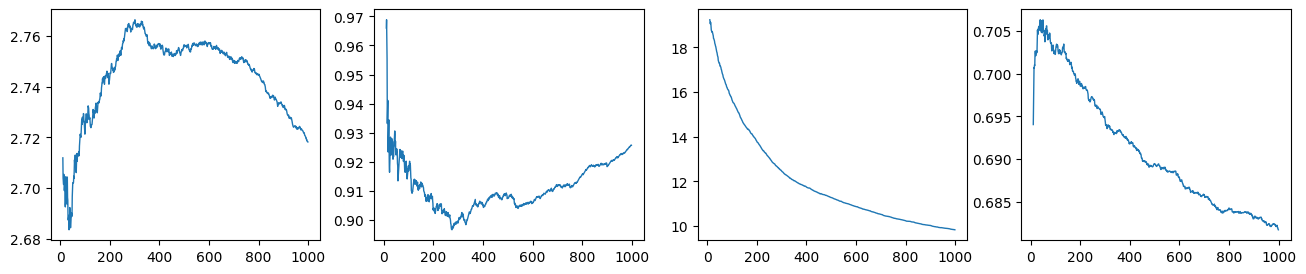

In [ ]:
print(len(losses))
plt.figure(figsize=(16, 3))
for i, s in enumerate([losses, accuracies, losses_mlm, losses_ce]):
    plt.subplot(1, 4, i+1)
    pd.Series(s).ewm(1000).mean()[10:].plot(lw=1);

In [ ]:
plot_for_report(losses, r"Значение функции ошибки $\mathcal{J}_{align}(\phi)$")

# plt.savefig('drive/MyDrive/diploma/loasses2_2k+1k+1k.pdf')
# plt.show()

In [ ]:
plot_for_report(accuracies, r"Точность")

# plt.savefig('drive/MyDrive/diploma/accuracies2_2k+1k+1k.pdf')
# plt.show()

In [ ]:
plot_for_report(losses_mlm, r"Значение функции ошибки $\mathcal{J}_{MLM}(\phi)$")

# plt.savefig('drive/MyDrive/diploma/losses2_MLM_2k+1k+1k.pdf')
# plt.show()

In [ ]:
test_model(model, tokenizer)

tensor([[ 0.9443,  0.5780, -0.1096, -0.1323, -0.1786],
        [ 0.4973,  0.9458, -0.1386, -0.0889, -0.0586],
        [-0.0801, -0.0540,  0.7642,  0.1174, -0.1049],
        [-0.1753, -0.0895,  0.0901,  0.7665, -0.1340],
        [-0.1045, -0.0774, -0.1100, -0.0030,  0.5081]], device='cuda:0')


In [ ]:
NEW_MODEL_NAME = 'drive/MyDrive/diploma/labse_moksha_50k+70k+1k'
model.save_pretrained(NEW_MODEL_NAME)
tokenizer.save_pretrained(NEW_MODEL_NAME)

('drive/MyDrive/diploma/labse_moksha_50k+70k+1k/tokenizer_config.json',
 'drive/MyDrive/diploma/labse_moksha_50k+70k+1k/special_tokens_map.json',
 'drive/MyDrive/diploma/labse_moksha_50k+70k+1k/vocab.txt',
 'drive/MyDrive/diploma/labse_moksha_50k+70k+1k/added_tokens.json')